In [1]:
%%capture
!pip install category_encoders==2.*

In [2]:
pip install xgboost

LIBRARIES 

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#metrics
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, plot_roc_curve, roc_curve, roc_auc_score, mean_absolute_error, r2_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Permutation Importance
from sklearn.inspection import permutation_importance 


IMPORT DATA SET

In [4]:
location = r'C:/Users/fivel/Documents/Assignments/Unit2/Unit2Project/openipf-latest/openipf-2021-12-15/openipf-2021-12-15-45b78b1a.csv'
df = pd.read_csv(location, low_memory=False)

In [5]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Karen Thomson,F,SBD,Single-ply,39.5,35-39,40-49,Masters 1,51.90,52,...,Yes,New Zealand,NaN,OceaniaPF,IPF,2002-12-06,New Zealand,BOP,Tauranga,Oceania Championships
1,Deborah Groves,F,SBD,Single-ply,30.5,24-34,24-39,Open,50.64,52,...,Yes,Australia,NaN,OceaniaPF,IPF,2002-12-06,New Zealand,BOP,Tauranga,Oceania Championships
2,Renee Orbon,F,SBD,Single-ply,31.5,24-34,24-39,Open,55.76,56,...,Yes,New Zealand,NaN,OceaniaPF,IPF,2002-12-06,New Zealand,BOP,Tauranga,Oceania Championships
3,Rikki Flanders,F,SBD,Single-ply,31.5,24-34,24-39,Open,56.42,60,...,Yes,Australia,NaN,OceaniaPF,IPF,2002-12-06,New Zealand,BOP,Tauranga,Oceania Championships
4,Julie Hallmond,F,SBD,Single-ply,NaN,NaN,50-59,Masters 2,58.20,60,...,Yes,New Zealand,NaN,OceaniaPF,IPF,2002-12-06,New Zealand,BOP,Tauranga,Oceania Championships


WRANGLE DATA 

In [6]:
#WRANGLING - YEE HAW 

def wrangle(df):
  df = pd.read_csv(location, parse_dates=['Date'], low_memory=False)
  
  #Select values only after year 2015

  mask = (df['Date'] >= '2015')
  df = df.loc[mask]

  #Convert the Date column into an 'object' dtype
    
  df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')


  #Drop missing values 
    
  df.dropna()

  #Edit Columns with only relevant information 
    
  df = df[df['Event'] == 'SBD']
  df = df[df['Equipment'] == 'Raw'] 
  df = df[df['Division'] == 'Open']
  df = df[df['Country'] == 'USA']


  #Dropping columns with too many missing values and/or irrelevant 

  df.drop(columns=['AgeClass', 'BirthYearClass', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg', 'Goodlift'], inplace=True)
    
  #remove HCCC 

  cutoff = 20
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)
    
    
  # Create a new feature that will serve as a target column
  # Create function that will define Lifter Level
    
  def LifterLevel(row):
    if row['Wilks'] >= 414: 
        return 'Elite'
    elif row['Wilks'] >= 326: 
        return 'Advanced'
    elif row['Wilks'] >= 238: 
        return 'Intermediate'
    else:
        return 'Novice'
    
    
  # apply to dataframe, use axis=1 to apply the function to every row
  
  df['LifterLevel'] = df.apply(LifterLevel, axis=1)


  # Drop 'Wilks' columns to prevent data leakage since it was used to create the target column 
    
  df.drop(columns='Wilks', inplace=True)  

  # Drop other leaky columns 
    
  df.drop(columns='Dots', inplace=True)
  df.drop(columns='Glossbrenner', inplace=True)
    
  return df

df= wrangle(df)

In [7]:
#Print data set header to check all wrangling has been applied 
df.head(10)

,Sex,Event,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,...,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Tested,Country,ParentFederation,LifterLevel
7253,F,SBD,Raw,26.5,Open,80.77,84,132.5,145.0,-157.5,...,137.5,150.0,160.0,160.0,390.0,5,Yes,USA,IPF,Advanced
7257,F,SBD,Raw,32.5,Open,80.85,84,115.0,120.0,-125.0,...,145.0,155.0,-162.5,155.0,340.0,9,Yes,USA,IPF,Intermediate
8513,F,SBD,Raw,31.5,Open,80.75,84,107.5,115.0,120.0,...,145.0,155.0,-160.0,155.0,340.0,3,Yes,USA,IPF,Intermediate
26553,F,SBD,Raw,32.5,Open,81.45,84,117.5,122.5,127.5,...,147.5,157.5,-162.5,157.5,352.5,2,Yes,USA,IPF,Intermediate
30467,M,SBD,Raw,27.0,Open,88.10,93,NaN,NaN,NaN,...,NaN,NaN,NaN,230.0,525.0,5,Yes,USA,IPF,Advanced
30561,M,SBD,Raw,26.0,Open,93.70,105,NaN,NaN,NaN,...,NaN,NaN,NaN,220.0,520.0,3,Yes,USA,IPF,Intermediate
32633,F,SBD,Raw,26.5,Open,80.95,84,95.0,105.0,-110.0,...,125.0,135.0,-137.5,135.0,297.5,8,Yes,USA,IPF,Intermediate
42685,M,SBD,Raw,28.5,Open,102.80,105,225.0,235.0,245.0,...,275.0,285.0,-295.0,285.0,695.0,2,Yes,USA,IPF,Elite
43089,M,SBD,Raw,37.5,Open,124.18,120+,180.0,190.0,195.0,...,215.0,230.0,-242.5,230.0,552.5,4,Yes,USA,IPF,Intermediate
45993,M,SBD,Raw,23.5,Open,88.10,93,195.0,205.0,210.0,...,240.0,252.5,260.0,260.0,607.5,1,Yes,USA,IPF,Advanced


In [8]:
df.shape

(735, 25)

CREATE TARGET AND SPLIT DATA 

In [9]:
#Define target column

target = 'LifterLevel'

#Divide the DataFrame df into the feature matrix X and the target vector y

y = df[target]
X = df.drop(columns=target)

Divide the dataset into training, validation, and test sets.

In [10]:
# Train-val split using 80-20 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Test-val split 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

ESTABLISH BASELINE

In [12]:
#Establish the baseline accuracy score for this classification problem using the training set. 

print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.4331065759637188


In [13]:
y.value_counts()

Elite           322
Advanced        249
Intermediate    127
Novice           37
Name: LifterLevel, dtype: int64

MODELS

Logistic Regression Model

In [14]:
#Create pipeline for Logistic Regression Model

model_lg = make_pipeline(
    OneHotEncoder(use_cat_names=True), # Encode categorical values
    
    SimpleImputer(strategy='mean'), # fills Nan values with column mean
    
    StandardScaler(), # re-scales all features  (mean = 0, std=1)
    
    LogisticRegression()
)


model_lg.fit(X_train, y_train);

Random Forest Model

In [15]:
#Create pipeline for Random Forest Tree-based Model 

model_rf = make_pipeline(
    
    OrdinalEncoder(),
    
    SimpleImputer(strategy='mean'),
    
    RandomForestClassifier(random_state=42, n_estimators=90, max_samples=.9, n_jobs=-1))


model_rf.fit(X_train, y_train);

CHECK METRICS

In [16]:
#Print accuracy scores for both models and label each 

print('LOGISTIC: Training Accuracy:', model_lg.score(X_train, y_train)) 
print('LOGISTIC: Validation Accuracy:', model_lg.score(X_val, y_val))
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val,y_val))

LOGISTIC: Training Accuracy: 0.9727891156462585
LOGISTIC: Validation Accuracy: 0.8299319727891157
FOREST: Training Accuracy: 1.0
FOREST: Validation Accuracy: 0.7619047619047619


CHECKING FOR DATA LEAKS

In [17]:
#Check for data leakage by exploring the feature importances of the Random Forest Model

#importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
#features = X_train.columns
#pd.Series(importances, index = features).sort_values().tail(10).plot(kind='barh');

We can see that the 'Wilks' column is creating leakage because it was used to create the target column. We need to go back to the Wrangling function and drop that column. 

In [18]:
#Checking feature importances again, now without the leaky column 

#importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
#features = X_train.columns
#pd.Series(importances, index = features).sort_values().tail(10).plot(kind='barh');

Judging by the new graph, we can see that the 'Dots' and 'Glossbrenner' columns could also be leaky. This could be because these two values also measure a lifter's strenght level (using different metrics than Wilks) 

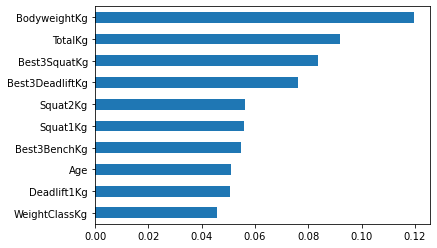

In [19]:
#Checking feature importances again, now without all leaky columns

importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index = features).sort_values().tail(10).plot(kind='barh');

TUNE RANDOM FOREST MODEL

In [20]:
# tuning n_estimators
# n_estimators = The number of trees in the forest.

train_acc = []
val_acc = []

num_of_estimators = np.arange(10,100,20)

for estimator in num_of_estimators:
  forest_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(n_estimators=estimator, random_state=42, n_jobs =-1) 
  )

  forest_model.fit(X_train, y_train)
  train_acc.append(forest_model.score(X_train, y_train))
  val_acc.append(forest_model.score(X_val, y_val))

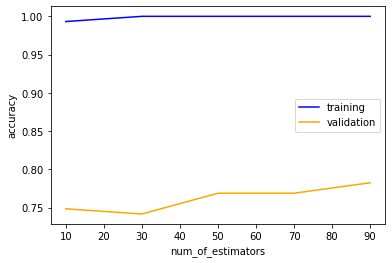

In [21]:
# Plot to find out optimal number of trees in the forest 

plt.plot(num_of_estimators, train_acc, color='blue', label='training')
plt.plot(num_of_estimators, val_acc, color='orange', label='validation')
plt.xlabel('num_of_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
# Applying n_sestimators to 90 and tuning max_samples

# max_samples = the number of samples to draw from X to train each base estimator


train_acc = []
val_acc = []
max_samples_values = np.arange(.2, 1, 0.1)
for sample_value in max_samples_values:
  forest_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(max_samples=sample_value, n_estimators=90, random_state=42, n_jobs =-1) 
  )
  forest_model.fit(X_train, y_train)
  train_acc.append(forest_model.score(X_train, y_train))
  val_acc.append(forest_model.score(X_val, y_val))

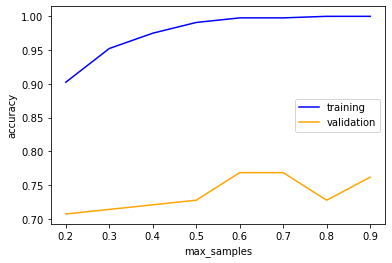

In [23]:
#Plot to find out optimal max_samples 

plt.plot(max_samples_values, train_acc, color='blue', label='training')
plt.plot(max_samples_values, val_acc, color='orange', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

COMMUNICATE RESULTS 

In [24]:
# Validation scores from both models

print('LOGISTIC: Validation Accuracy:', model_lg.score(X_val, y_val))
print('FOREST: Validation Accuracy:', model_rf.score(X_val,y_val))

# Test score from Logistic Regression Model 

print('LOGISTIC: Test Accuracy:', model_lg.score(X_test, y_test))


LOGISTIC: Validation Accuracy: 0.8299319727891157
FOREST: Validation Accuracy: 0.7619047619047619
LOGISTIC: Test Accuracy: 0.8639455782312925
